# Modelling Notebook
## Less structured exploratory work identifying best paths forward
This notebook is less well-structured and includes mostly exploratory work. This is where we built full-scale XGBoost and RandomForest models with hyperparameter tuning. We decided to operationalize our logistic regression for reasons explored in the paper, but have left this work as opportunities for future exploration.

In [12]:
import pandas as pd
import numpy as np

# import the packages needed to
# 1. Develop an xgboost or other gradient boosting model
# 2. Encode text data for use in the xgboost model
# 3. Evaluate the model including gini and ROC curve, variable importance, effective size
# 4. Tune the model

# import the packages
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import log_loss
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from xgboost import XGBClassifier
from xgboost import plot_importance
import matplotlib.pyplot as plt
import seaborn as sns
import pyarrow.parquet as pq
import polars as pl
import gc

filepath = "C:/Users/shane/Downloads/analyticsDF.parquet"

analyticsDF = pl.read_parquet(filepath)
colsToFix = {
    "loan_amount": "int64",
    "tract_population": "int64",
}

for col in colsToFix:
    analyticsDF = analyticsDF.with_columns([pl.col(col).cast(pl.Int64)])
colsToFill = {
    "loan_term": {-99: 360},
    
}
for col in colsToFill:
    analyticsDF = analyticsDF.with_columns([pl.col(col).replace(colsToFill[col])])
colsToImpute = [
    "interest_rate",
    "intro_rate_period",
    "prepayment_penalty_term",
    "discount_points",
    "total_points_and_fees",
    "multifamily_affordable_units",
    "total_loan_costs",
    "total_points_and_fees",
    "origination_charges",
    "discount_points",
    "lender_credits",
    "prepayment_penalty_term",
    "intro_rate_period",
]
for col in colsToImpute:
    analyticsDF = analyticsDF.with_columns([pl.col(col).replace(-99, np.nan)])
    meanVal = analyticsDF[col].mean()
    analyticsDF = analyticsDF.with_columns([pl.col(col).fill_null(meanVal)])
    
cols = analyticsDF.columns

countyDF = analyticsDF.select([
    "county_code", "activity_year", "census_tract", "tract_population", "tract_minority_population_percent",
    "tract_to_msa_income_percentage", "tract_owner_occupied_units", "tract_one_to_four_family_homes",
    "tract_median_age_of_housing_units"
])

# deduplicate on county_code, activity_year, census_tract to get the first instance of each
countyDF = countyDF.group_by(["county_code", "activity_year", "census_tract"]).first()

# calculate the weighted value of each of the columns
countyDF = countyDF.with_columns(
    (pl.col("tract_population") * pl.col("tract_minority_population_percent")).alias("minority_population_weighted"),
    (pl.col("tract_population") * pl.col("tract_to_msa_income_percentage")).alias("income_weighted"),
    (pl.col("tract_population") * pl.col("tract_median_age_of_housing_units")).alias("median_age_weighted")
)

# group by county_code and activity_yea

countyDF = countyDF.group_by(["county_code", "activity_year"]).agg([
    pl.sum("tract_population").alias("county_population"),
    pl.sum("minority_population_weighted").alias("minority_population_percent"),
    pl.sum("income_weighted").alias("avg_msa_income_percent"),
    pl.sum("tract_owner_occupied_units").alias("county_owner_occupied_units"),
    pl.sum("tract_one_to_four_family_homes").alias("county_one_to_four_family_homes"),
    pl.sum("median_age_weighted").alias("county_avg_housing_age")
])

# convert weighted values back to percentages
countyDF = countyDF.with_columns(
    (pl.col("minority_population_percent") / pl.col("county_population")).alias("minority_population_percent"),
    (pl.col("avg_msa_income_percent") / pl.col("county_population")).alias("avg_msa_income_percent"),
    (pl.col("county_avg_housing_age") / pl.col("county_population")).alias("county_avg_housing_age")
)

# merge the countyDF back on
analyticsDF = analyticsDF.join(
    countyDF, on=["county_code", "activity_year"], how="left"
)

descriptiveCols = [
    "activity_year",
    "lei",
    "derived_msa_md",
    "census_tract",
]

countyColsToAgg = [
    "tract_population", "tract_minority_population_percent", "tract_to_msa_income_percentage",
    "tract_owner_occupied_units", "tract_one_to_four_family_homes", "tract_median_age_of_housing_units",
    
]

colsToDrop = [
    "loan_purpose", "reverse_mortgage", "open_end_line_of_credit", "tract_population", "tract_minority_population_percent", "tract_to_msa_income_percentage",
    "tract_owner_occupied_units", "tract_one_to_four_family_homes", "tract_median_age_of_housing_units", "denial_reasons"
]

categoryCols = [
    "state_code", "county_code", "conforming_loan_limit", "derived_loan_product_type",
    "derived_dwelling_category", "derived_ethnicity", "derived_race", "derived_sex",
    "action_taken", "purchaser_type", "loan_type", "loan_purpose", "lien_status",
    "hoepa_status", "construction_method", "occupancy_type", "debt_to_income_ratio",
    "applicant_credit_score_type", "co_applicant_credit_score_type", "applicant_age",
    "co_applicant_age", "co_applicant_age_above_62", "applicant_age_above_62", "aus_1",
    "aus_2", "aus_3", "aus_4", "aus_5", "applicant_ethnicitys", "co_applicant_ethnicitys",
    "applicant_races", "co_applicant_races",  "total_units"
]    

numCols = [
    "loan_amount", "combined_loan_to_value_ratio", "interest_rate", "rate_spread",
    "total_loan_costs", "total_points_and_fees", "origination_charges", "discount_points",
    "lender_credits", "loan_term", "prepayment_penalty_term", "intro_rate_period",
    "property_value", "multifamily_affordable_units", "income", "total_units_val",
    "debt_to_income_ratio_val", 
]

boolCols = [
    "preapproval", "business_or_commercial_purpose", "negative_amortization", "interest_only_payment",
    "balloon_payment", "other_nonamortizing_features",
]


def replaceWithMedian(df1, df2, col, county=True):
    onCol = "county_code" if county else "activity_year"
    df1 = df1.join(df2, on=onCol, how="left")
    df1 = df1.with_columns([
        pl.col(col).fill_null(pl.col(col + "_median"))
    ])
    df1 = df1.with_columns([
        pl.col(col).fill_nan(pl.col(col + "_median"))
    ])
    df1 = df1.drop(col + "_median")
    return df1

def investigateColumn(df, col):

    series = df[col]
    # if column dtype is str, convert to category
    if series.dtype == pl.Utf8:
        if series.is_null().sum() > 0:
            print(f"Column {col}: {series.dtype} contains null values")
        return(df)
    else:
        if series.is_nan().sum() > 0:
            print(f"Column {col}: {series.dtype} contains NaN values")
            print(series.is_nan().sum())
            print("filling with median")
            # group by county_code taking the median of the column, then replacing the nan vals with that county's median
            medianValCounty = df.\
                filter(pl.col(col).is_not_null() & pl.col(col).is_not_nan()).\
                group_by("county_code").\
                agg([pl.median(col).alias(col+"_median")])
            print(medianValCounty.head(1))
            medianVal = df.\
                filter(pl.col(col).is_not_null() & pl.col(col).is_not_nan()).\
                group_by("activity_year").\
                agg([pl.median(col).alias(col+"_median")])
            print(medianVal)
            df = replaceWithMedian(df, medianValCounty, col, county=True)
            df = replaceWithMedian(df, medianVal, col, county=False)
            print(f"After filling with medians, there are {df[col].is_nan().sum()} missing values")
        if series.is_infinite().sum() > 0:
            print(f"Column {col}: {series.dtype} contains infinity values")
        try:
            series = series.cast(pl.Float32)
            if series.is_infinite().sum() > 0:
                print(f"Column {col}: {series.dtype} contains values too large for dtype('float32')")
        except:
            print(f"Column {col}: {series.dtype} contains non-numeric values")
    return df

# first drop the columns
analyticsDFFinal = analyticsDF.drop(colsToDrop)

# filter for values in action_taken that are not 4 or 5
# recode action_taken

actionTakenRecode = {
    "1": 1,
    "2": 1,
    "3": 0,
    "6": 1,
    "7": 0,
    "8": 1
}

analyticsDFFinal = analyticsDFFinal.filter(pl.col("action_taken")!="4").filter(pl.col("action_taken")!="5").with_columns([
    pl.col("action_taken").replace(actionTakenRecode).alias("action_taken")
])

# multiply income by 1000, since it's measured in thousands
analyticsDFFinal = analyticsDFFinal.with_columns([
    (pl.col("income") * 1000).alias("income")
])

valsToSplitAndExplode = [
    'applicant_ethnicitys',
    'co_applicant_ethnicitys',
    'applicant_races',
    'co_applicant_races',
]

print("Initial shape:", analyticsDFFinal.shape)

for col in valsToSplitAndExplode:
    # Corrected approach: Use str.split for splitting on "|"
    analyticsDFFinal = analyticsDFFinal.with_columns([
        pl.col(col).str.split("|").alias(col)
    ]).explode(col)
    
    print(f"After exploding {col}:", analyticsDFFinal.shape)

# now for col in valsToSplitAndExplode, fill "" with "Missing"

for col in valsToSplitAndExplode:
    analyticsDFFinal = analyticsDFFinal.with_columns([
        pl.col(col).replace("", "Missing")
    ])

print("Final shape:", analyticsDFFinal.shape)

for col in valsToSplitAndExplode:
    analyticsDFFinal = analyticsDFFinal.with_columns([
        pl.col(col).replace("", "None")
    ])

encodedLabels = {}

# encode the bool columns
for col in boolCols:
    print(col)
    if col not in analyticsDFFinal.columns:
        print("not in columns")
        continue
    analyticsDFFinal = analyticsDFFinal.with_columns([
        pl.col(col).cast(pl.Int64).alias(col)
    ])

for col in analyticsDFFinal.columns:
    analyticsDFFinal = investigateColumn(analyticsDFFinal, col)
    
# okay, let's work on imputing missing numerical values with the median value

for col in numCols:
    # replace -99 with nan or nulls
    # fill nulls with the median value
    series = analyticsDFFinal[col].replace(-99, None)
    medianVal = series.drop_nulls().median()
    analyticsDFFinal = analyticsDFFinal.with_columns([
        series.fill_null(medianVal).alias(col)
    ])

analyticsDFRFFinal = analyticsDFFinal.clone()

# # encode the category columns
# for col in categoryCols:
#     print(col)
#     if col not in analyticsDFFinal.columns:
#         print("not in columns")
#         continue
#     le = LabelEncoder()
#     transformation = le.fit_transform(analyticsDFFinal[col])
#     analyticsDFFinal = analyticsDFFinal.drop(col).with_columns([
#         pl.Series(transformation).alias(col)
#     ])
#     encodedLabels[col] = le



for col in analyticsDFFinal.columns:
    analyticsDFFinal = investigateColumn(analyticsDFFinal, col)

for col in analyticsDFRFFinal.columns:
    analyticsDFRFFinal = investigateColumn(analyticsDFRFFinal, col)

# split the data into predictors and target
sampleDF = analyticsDFFinal.sample(fraction=0.3)# .to_pandas()
sampleDFRF = analyticsDFRFFinal.sample(fraction=0.3)# .to_pandas()


Initial shape: (8211413, 66)
After exploding applicant_ethnicitys: (8235629, 66)
After exploding co_applicant_ethnicitys: (8246172, 66)
After exploding applicant_races: (8362424, 66)
After exploding co_applicant_races: (8431090, 66)
Final shape: (8431090, 66)
preapproval
business_or_commercial_purpose
negative_amortization
interest_only_payment
balloon_payment
other_nonamortizing_features
Column interest_rate: Float64 contains NaN values
1011557
filling with median
shape: (1, 2)
┌─────────────┬──────────────────────┐
│ county_code ┆ interest_rate_median │
│ ---         ┆ ---                  │
│ str         ┆ f64                  │
╞═════════════╪══════════════════════╡
│ 48275       ┆ 4.125                │
└─────────────┴──────────────────────┘
shape: (5, 2)
┌───────────────┬──────────────────────┐
│ activity_year ┆ interest_rate_median │
│ ---           ┆ ---                  │
│ str           ┆ f64                  │
╞═══════════════╪══════════════════════╡
│ 2021          ┆ 3.0   

In [13]:
# convert a polars dataframe to parquet table, then write the table to a parquet file for use in other platforms

sampleDF.write_parquet("C:/Users/shane/Downloads/sampleDF.parquet")
analyticsDFFinal.write_parquet("C:/Users/shane/Downloads/analyticsDFFinal.parquet")
analyticsDFFinal.write_csv("C:/Users/shane/Downloads/analyticsDFFinal.csv")

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.model_selection import GridSearchCV
from xgboost import plot_importance
import matplotlib.pyplot as plt
import seaborn as sns
import pyarrow.parquet as pq
import polars as pl
from polars import lit
from sklearn.ensemble import RandomForestClassifier

analyticsDFFinal = pl.read_parquet("C:/Users/shane/Downloads/analyticsDFFinal.parquet")

# Get unique races and ethnicities
uniqueRaces = (analyticsDFFinal["applicant_races"].append(analyticsDFFinal["co_applicant_races"])).unique()
uniqueEthnicities = (analyticsDFFinal["applicant_ethnicitys"].append(analyticsDFFinal["co_applicant_ethnicitys"])).unique()

# Remove duplicates from the lists
uniqueRaces = list(set(uniqueRaces))
uniqueEthnicities = list(set(uniqueEthnicities))

# One-hot encoding for races
for race in uniqueRaces:
    analyticsDFFinal = analyticsDFFinal.with_columns([
        pl.when((pl.col("applicant_races") == lit(race)) | (pl.col("co_applicant_races") == lit(race))).then(1).otherwise(0).alias("race_" + race)
    ])

# One-hot encoding for ethnicities
for ethnicity in uniqueEthnicities:
    analyticsDFFinal = analyticsDFFinal.with_columns([
        pl.when((pl.col("applicant_ethnicitys") == lit(ethnicity)) | (pl.col("co_applicant_ethnicitys") == lit(ethnicity))).then(1).otherwise(0).alias("ethn_" + ethnicity)
    ])
    
descriptiveCols = [
    "activity_year",
    "lei",
    "derived_msa_md",
    "census_tract",
    "applicant_races",
    "co_applicant_races",
    "applicant_ethnicitys",
    "co_applicant_ethnicitys",
    "aus_1", "aus_2", "aus_3", "aus_4", "aus_5",
    "derived_ethnicity", "derived_race", "derived_sex"
]

categoryCols = [
    "state_code", "county_code", "conforming_loan_limit", "derived_loan_product_type",
    "derived_dwelling_category", "derived_ethnicity", "derived_race", "derived_sex",
    "action_taken", "purchaser_type", "loan_type", "loan_purpose", "lien_status",
    "hoepa_status", "construction_method", "occupancy_type", "debt_to_income_ratio",
    "applicant_credit_score_type", "co_applicant_credit_score_type", "applicant_age",
    "co_applicant_age", "co_applicant_age_above_62", "applicant_age_above_62", "aus_1",
    "aus_2", "aus_3", "aus_4", "aus_5", "applicant_ethnicitys", "co_applicant_ethnicitys",
    "applicant_races", "co_applicant_races",  "total_units"
]

encodedLabels = {}

# encode the category columns
for col in categoryCols:
    print(col)
    if col not in analyticsDFFinal.columns:
        print("not in columns")
        continue
    le = LabelEncoder()
    transformation = le.fit_transform(analyticsDFFinal[col])
    analyticsDFFinal = analyticsDFFinal.drop(col).with_columns([
        pl.Series(transformation).alias(col)
    ])
    encodedLabels[col] = le




state_code
county_code
conforming_loan_limit
derived_loan_product_type
derived_dwelling_category
derived_ethnicity
derived_race
derived_sex
action_taken
purchaser_type
loan_type
loan_purpose
not in columns
lien_status
hoepa_status
construction_method
occupancy_type
debt_to_income_ratio
applicant_credit_score_type
co_applicant_credit_score_type
applicant_age
co_applicant_age
co_applicant_age_above_62
applicant_age_above_62
aus_1
aus_2
aus_3
aus_4
aus_5
applicant_ethnicitys
co_applicant_ethnicitys
applicant_races
co_applicant_races
total_units


ValueError: could not convert string to float: '254900HA4DQWAE0W3342'

In [4]:

# build a train and validate set for our final RF model
X = analyticsDFFinal.drop(["action_taken"])
X = X.drop([col for col in X.columns if col in descriptiveCols])
y = analyticsDFFinal["action_taken"]

X_train, X_validate, y_train, y_validate = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=4282,
    stratify=y
)

# Best RF Parameters
bestRFParams = {'n_estimators': 700,
 'min_samples_split': 42,
 'min_samples_leaf': 1,
 'max_depth': None}

rf = RandomForestClassifier(
    n_estimators=bestRFParams["n_estimators"],
    min_samples_split=bestRFParams["min_samples_split"],
    min_samples_leaf=bestRFParams["min_samples_leaf"],
    max_depth=bestRFParams["max_depth"],
    random_state=4282
)

finalModel = rf.fit(X_train, y_train)

# get the feature importances
featureImportances = finalModel.feature_importances_


NameError: name 'pd' is not defined

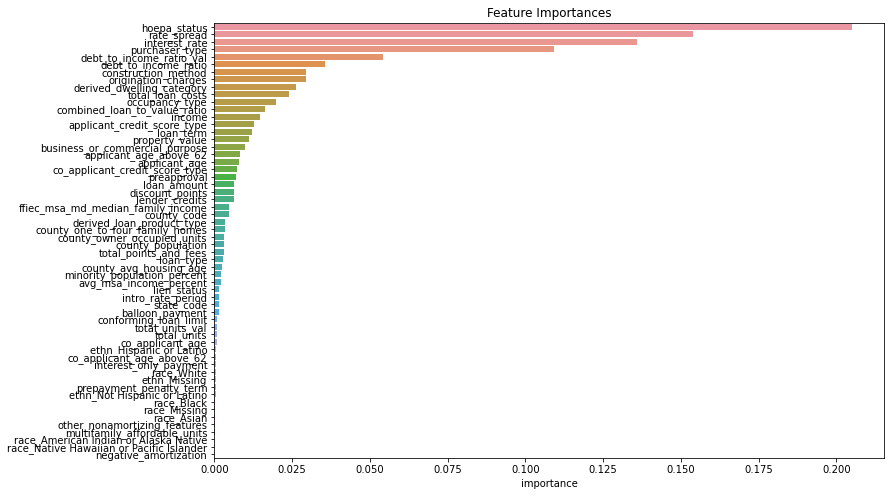

NameError: name 'roc_curve' is not defined

In [5]:
import pandas as pd
featureImportances = pd.DataFrame(featureImportances, index=X.columns, columns=["importance"])
featureImportances = featureImportances.sort_values(by="importance", ascending=False)

# plot the feature importances.
plt.figure(figsize=(12, 8))
sns.barplot(x=featureImportances.importance, y=featureImportances.index)
plt.title("Feature Importances")
plt.show()

# get the predictions
y_train_preds = finalModel.predict(X_train)
y_validate_preds = finalModel.predict(X_validate)

# get the probabilities
y_train_probs = finalModel.predict_proba(X_train)[:, 1]
y_validate_probs = finalModel.predict_proba(X_validate)[:, 1]

# get the ROC curve
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_probs)
fpr_validate, tpr_validate, thresholds_validate = roc_curve(y_validate, y_validate_probs)

# get the AUC

auc_train = auc(fpr_train, tpr_train)
auc_validate = auc(fpr_validate, tpr_validate)


In [60]:
# sampleDF = analyticsDFFinal.sample(fraction=0.3)# .to_pandas()

# let's build a regression using variable selection (lasso, ridge, elastic net)
# then let's build a logit with the best model from that

sampleDFLogit = sampleDF.clone()

descriptiveCols = [
    "activity_year",
    "lei",
    "derived_msa_md",
    "census_tract",
    "applicant_races",
    "co_applicant_races",
    "applicant_ethnicitys",
    "co_applicant_ethnicitys",
    "aus_1", "aus_2", "aus_3", "aus_4", "aus_5",
    "derived_ethnicity", "derived_race", "derived_sex"
    
]

sampleDFLogit = sampleDFLogit.drop(descriptiveCols)
# encode the category columns
for col in categoryCols:
    print(col)
    if col not in sampleDFLogit.columns:
        print("not in columns")
        continue
    le = LabelEncoder()
    transformation = le.fit_transform(sampleDFLogit[col])
    sampleDFLogit = sampleDFLogit.drop(col).with_columns([
        pl.Series(transformation).alias(col)
    ])
    encodedLabels[col] = le
    
trainDF, testDF = train_test_split(
    sampleDFLogit,
    test_size=0.3,
    shuffle=True,
    random_state=4282,
    stratify=sampleDF["action_taken"]
)

trainPredictors = trainDF.drop("action_taken")
trainPredictors = trainPredictors.to_pandas()
trainTarget = trainDF["action_taken"].to_pandas()

testPredictors = testDF.drop("action_taken")
testPredictors = testPredictors.to_pandas()
testTarget = testDF["action_taken"].to_pandas()



from sklearn.linear_model import LogisticRegression

import statsmodels.api as sm

# Add a constant to the predictors
X = sm.add_constant(trainPredictors)

# Fit the model
model = sm.Logit(trainTarget, X)
result = model.fit()

# Get the summary
print(result.summary())


state_code


county_code
conforming_loan_limit
derived_loan_product_type
derived_dwelling_category
derived_ethnicity
not in columns
derived_race
not in columns
derived_sex
not in columns
action_taken
purchaser_type
loan_type
loan_purpose
not in columns
lien_status
hoepa_status
construction_method
occupancy_type
debt_to_income_ratio
applicant_credit_score_type
co_applicant_credit_score_type
applicant_age
co_applicant_age
co_applicant_age_above_62
applicant_age_above_62
aus_1
not in columns
aus_2
not in columns
aus_3
not in columns
aus_4
not in columns
aus_5
not in columns
applicant_ethnicitys
not in columns
co_applicant_ethnicitys
not in columns
applicant_races
not in columns
co_applicant_races
not in columns
total_units
Optimization terminated successfully.
         Current function value: 0.100981
         Iterations 12
                           Logit Regression Results                           
Dep. Variable:           action_taken   No. Observations:              1770528
Model:                

In [61]:
# import the packages needed for a random forest and svm models
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC


trainDF, testDF = train_test_split(
    sampleDF,
    test_size=0.3,
    shuffle=True,
    random_state=4282,
    stratify=sampleDF["action_taken"]
)


# build the random forest model
rf = RandomForestClassifier(
    n_estimators=100,
    random_state=4282,
    criterion="gini",
    n_jobs=-1,
    )


rf.fit(
    trainPredictors,
    trainTarget
)
     
# now tune hyperparameters

params = {
    "n_estimators": [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],  # Broader range
    "max_depth": [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],  # Broader range
    "min_samples_split": np.arange(2, 200, 20),  # Broader range and increased step size
    "min_samples_leaf": np.arange(1, 200, 20),  # Broader range and increased step size
}

# tune the model
randomSearch = RandomizedSearchCV(
    estimator=rf,
    param_distributions=params,
    n_iter=100,
    scoring="roc_auc",
    n_jobs=-1,
    cv=3,
    verbose=3,   
)
    

randomSearch.fit(trainPredictors, trainTarget)

# get the best parameters
bestParamsrf = randomSearch.best_params_

# fit a model with best_params
rfFinal = RandomForestClassifier(
    n_estimators=bestParamsrf["n_estimators"],
    max_depth=bestParamsrf["max_depth"],
    min_samples_split=bestParamsrf["min_samples_split"],
    min_samples_leaf=bestParamsrf["min_samples_leaf"],
    random_state=4282,
    criterion="gini",
    n_jobs=-1,
    verbose=3
    )

# now fit the model
rfFinal.fit(
    trainPredictors,
    trainTarget
)

# get the predictions
trainPredictionsRF = rfFinal.predict(trainPredictors)
testPredictionsRF = rfFinal.predict(testPredictors)

# get the probabilities
trainProbabilitiesRF = rfFinal.predict_proba(trainPredictors)[:, 1]
testProbabilitiesRF = rfFinal.predict_proba(testPredictors)[:, 1]

# get the roc_auc score
trainAUCRF = roc_auc_score(trainTarget, trainProbabilitiesRF)
testAUCRF = roc_auc_score(testTarget, testProbabilitiesRF)

# get the confusion matrix
trainConfusionRF = confusion_matrix(trainTarget, trainPredictionsRF)
testConfusionRF = confusion_matrix(testTarget, testPredictionsRF)

# get the classification report
trainReportRF = classification_report(trainTarget, trainPredictionsRF)
testReportRF = classification_report(testTarget, testPredictionsRF)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


building tree 1 of 700
building tree 2 of 700building tree 3 of 700

building tree 4 of 700
building tree 5 of 700
building tree 6 of 700
building tree 7 of 700
building tree 8 of 700building tree 9 of 700

building tree 10 of 700building tree 11 of 700

building tree 12 of 700
building tree 13 of 700
building tree 14 of 700
building tree 15 of 700
building tree 16 of 700
building tree 17 of 700
building tree 18 of 700
building tree 19 of 700


[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    5.0s


building tree 20 of 700
building tree 21 of 700
building tree 22 of 700
building tree 23 of 700
building tree 24 of 700
building tree 25 of 700
building tree 26 of 700
building tree 27 of 700
building tree 28 of 700
building tree 29 of 700
building tree 30 of 700
building tree 31 of 700
building tree 32 of 700
building tree 33 of 700
building tree 34 of 700
building tree 35 of 700
building tree 36 of 700
building tree 37 of 700
building tree 38 of 700
building tree 39 of 700
building tree 40 of 700
building tree 41 of 700
building tree 42 of 700
building tree 43 of 700
building tree 44 of 700
building tree 45 of 700
building tree 46 of 700
building tree 47 of 700
building tree 48 of 700
building tree 49 of 700
building tree 50 of 700
building tree 51 of 700
building tree 52 of 700
building tree 53 of 700
building tree 54 of 700
building tree 55 of 700
building tree 56 of 700
building tree 57 of 700
building tree 58 of 700
building tree 59 of 700
building tree 60 of 700
building tree 61

[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:   45.1s



building tree 117 of 700
building tree 118 of 700
building tree 119 of 700
building tree 120 of 700
building tree 121 of 700
building tree 122 of 700
building tree 123 of 700
building tree 124 of 700
building tree 125 of 700
building tree 126 of 700
building tree 127 of 700
building tree 128 of 700
building tree 129 of 700
building tree 130 of 700
building tree 131 of 700
building tree 132 of 700
building tree 133 of 700
building tree 134 of 700
building tree 135 of 700
building tree 136 of 700building tree 137 of 700

building tree 138 of 700
building tree 139 of 700
building tree 140 of 700
building tree 141 of 700
building tree 142 of 700
building tree 143 of 700
building tree 144 of 700
building tree 145 of 700
building tree 146 of 700
building tree 147 of 700
building tree 148 of 700
building tree 149 of 700
building tree 150 of 700
building tree 151 of 700
building tree 152 of 700
building tree 153 of 700
building tree 154 of 700
building tree 155 of 700
building tree 156 of 700

[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:  1.9min


building tree 276 of 700
building tree 277 of 700
building tree 278 of 700
building tree 279 of 700
building tree 280 of 700
building tree 281 of 700
building tree 282 of 700
building tree 283 of 700
building tree 284 of 700
building tree 285 of 700
building tree 286 of 700
building tree 287 of 700
building tree 288 of 700
building tree 289 of 700
building tree 290 of 700
building tree 291 of 700
building tree 292 of 700
building tree 293 of 700
building tree 294 of 700
building tree 295 of 700
building tree 296 of 700
building tree 297 of 700
building tree 298 of 700
building tree 299 of 700
building tree 300 of 700
building tree 301 of 700
building tree 302 of 700
building tree 303 of 700
building tree 304 of 700
building tree 305 of 700
building tree 306 of 700
building tree 307 of 700
building tree 308 of 700
building tree 309 of 700
building tree 310 of 700
building tree 311 of 700
building tree 312 of 700
building tree 313 of 700
building tree 314 of 700
building tree 315 of 700


[Parallel(n_jobs=-1)]: Done 488 tasks      | elapsed:  3.4min


building tree 500 of 700
building tree 501 of 700
building tree 502 of 700
building tree 503 of 700
building tree 504 of 700
building tree 505 of 700building tree 506 of 700

building tree 507 of 700
building tree 508 of 700
building tree 509 of 700
building tree 510 of 700
building tree 511 of 700
building tree 512 of 700
building tree 513 of 700
building tree 514 of 700
building tree 515 of 700
building tree 516 of 700
building tree 517 of 700
building tree 518 of 700
building tree 519 of 700
building tree 520 of 700
building tree 521 of 700
building tree 522 of 700
building tree 523 of 700
building tree 524 of 700
building tree 525 of 700
building tree 526 of 700
building tree 527 of 700
building tree 528 of 700
building tree 529 of 700
building tree 530 of 700
building tree 531 of 700
building tree 532 of 700
building tree 533 of 700
building tree 534 of 700
building tree 535 of 700
building tree 536 of 700
building tree 537 of 700
building tree 538 of 700
building tree 539 of 700


[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:  4.9min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 104 tasks      | elapsed:    2.7s
[Parallel(n_jobs=12)]: Done 264 tasks      | elapsed:    6.7s
[Parallel(n_jobs=12)]: Done 488 tasks      | elapsed:   12.8s
[Parallel(n_jobs=12)]: Done 700 out of 700 | elapsed:   18.5s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 104 tasks      | elapsed:    1.2s
[Parallel(n_jobs=12)]: Done 264 tasks      | elapsed:    3.0s
[Parallel(n_jobs=12)]: Done 488 tasks      | elapsed:    5.6s
[Parallel(n_jobs=12)]: Done 700 out of 700 | elapsed:    8.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   8 tasks      | 

{'n_estimators': 700,
 'min_samples_split': 42,
 'min_samples_leaf': 1,
 'max_depth': None}

In [ ]:
# Best RF Params


In [ ]:

# now svm
svm = SVC(random_state=4282)
svm.fit(trainDF.drop("action_taken"), trainDF["action_taken"])

# tune the model
params = {
    "C": [0.1, 1, 10, 100],
    "gamma": [1, 0.1, 0.01, 0.001],
    "kernel": ["rbf", "poly", "sigmoid"]
}

grid = GridSearchCV(
    svm,
    params,
    cv=3,
    n_jobs=-1,
    verbose=3,
    scoring="roc_auc"
    )

grid.fit(trainDF.drop("action_taken"), trainDF["action_taken"])

bestParamsSVM = grid.best_params_


In [ ]:

# build the model with the best parameters
rfFinal = RandomForestClassifier(
    n_estimators=bestParamsrf["n_estimators"],
    max_depth=bestParamsrf["max_depth"],
    min_samples_split=bestParamsrf["min_samples_split"],
    min_samples_leaf=bestParamsrf["min_samples_leaf"],
    random_state=4282
)

trainDFRF, testDFRF = train_test_split(
    analyticsDFRFFinal,
    test_size=0.3,
    shuffle=True,
    random_state=4282,
    stratify=analyticsDFRFFinal["action_taken"]
)

finalRFModel = rfFinal.fit(trainDFRF.drop("action_taken"), trainDFRF["action_taken"])

In [50]:

# split the data into predictors and target
trainPredictors = trainDF.drop("action_taken")
trainPredictors = trainPredictors.drop(descriptiveCols).to_pandas()
trainTarget = trainDF["action_taken"].to_pandas()

testPredictors = testDF.drop("action_taken")
testPredictors = testPredictors.drop(descriptiveCols).to_pandas()
testTarget = testDF["action_taken"].to_pandas()

bestParams = {
    'colsample_bytree': 0.5,
    'learning_rate': 0.01,
    'max_depth': 7,
    'n_estimators': 1000,
    'subsample': 1.0
}

# build the model
model = XGBClassifier(
    n_estimators=bestParams["n_estimators"],
    max_depth=bestParams["max_depth"],
    learning_rate=bestParams["learning_rate"],
    subsample=bestParams["subsample"],
    colsample_bytree=bestParams["colsample_bytree"],
    objective="binary:logistic",
    eval_metric="logloss",
    use_label_encoder=True
)

In [ ]:

# fit the model
model.fit(trainPredictors, trainTarget)

# make predictions
trainPredictions = model.predict(trainPredictors.to_numpy())
testPredictions = model.predict(testPredictors.to_numpy())

# calculate the accuracy
trainAccuracy = accuracy_score(trainTarget.to_numpy(), trainPredictions)
testAccuracy = accuracy_score(testTarget.to_numpy(), testPredictions)

# calculate the precision
trainPrecision = precision_score(trainTarget.to_numpy(), trainPredictions)
testPrecision = precision_score(testTarget.to_numpy(), testPredictions)

# calculate the recall
trainRecall = recall_score(trainTarget.to_numpy(), trainPredictions)
testRecall = recall_score(testTarget.to_numpy(), testPredictions)

# calculate the f1 score
trainF1 = f1_score(trainTarget.to_numpy(), trainPredictions)
testF1 = f1_score(testTarget.to_numpy(), testPredictions)

# calculate the log loss
trainLogLoss = log_loss(trainTarget.to_numpy(), model.predict_proba(trainPredictors.to_numpy()))
testLogLoss = log_loss(testTarget.to_numpy(), model.predict_proba(testPredictors.to_numpy()))

# calculate the roc auc
trainROCAUC = roc_auc_score(trainTarget.to_numpy(), model.predict_proba(trainPredictors.to_numpy())[:,1])
testROCAUC = roc_auc_score(testTarget.to_numpy(), model.predict_proba(testPredictors.to_numpy())[:,1])

# calculate the confusion matrix
trainConfusionMatrix = confusion_matrix(trainTarget.to_numpy(), trainPredictions)
testConfusionMatrix = confusion_matrix(testTarget.to_numpy(), testPredictions)

# calculate the classification report
trainClassificationReport = classification_report(trainTarget.to_numpy(), trainPredictions)
testClassificationReport = classification_report(testTarget.to_numpy(), testPredictions)

# show importance


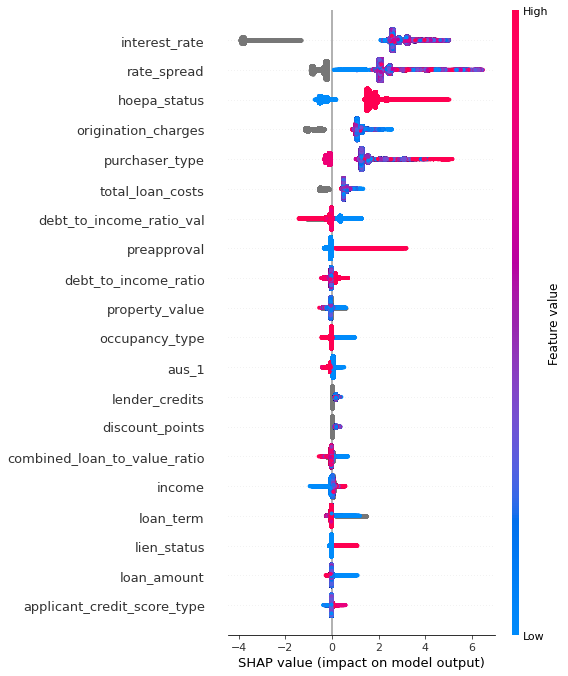

In [10]:
# now use shap on my model to show both feature importance AND the direction that each feature's values impact the model

import shap

# create a shap explainer
explainer = shap.Explainer(model)

# calculate the shap values
shap_values = explainer.shap_values(trainPredictors)

# plot the shap values
shap.summary_plot(shap_values, trainPredictors)

In [51]:
# create a parameter grid
paramGrid = {
    "max_depth": [3, 5, 7],
    "n_estimators": [100, 300, 500, 700, 1000],
    "learning_rate": [0.01, 0.05, 0.1, 0.3],
    "subsample": [0.3, 0.5, 0.8, 1.0],
    "colsample_bytree": [0.3, 0.5, 0.8, 1.0],
}

# create the grid search
gridSearch = GridSearchCV(
    estimator=model,
    param_grid=paramGrid,
    scoring="roc_auc",
    n_jobs=-1,  # use all available cores
    cv=2,  # 2-fold cross-validation
    verbose=3
)

# fit the grid search on the training data
gridSearch.fit(trainPredictors.to_numpy(), trainTarget.to_numpy())

# get the best parameters
bestParams = gridSearch.best_params_

# print the best parameters
print(f"Best parameters: {bestParams}")

# fit the model with the best parameters on the training data
model.set_params(**bestParams)
model.fit(trainPredictors.to_numpy(), trainTarget.to_numpy())

# make predictions on the test data
testPredictions = model.predict(testPredictors.to_numpy())

# calculate the accuracy on the test data
testAccuracy = accuracy_score(testTarget.to_numpy(), testPredictions)

# print the test accuracy
print(f"Test accuracy: {testAccuracy}")

Fitting 2 folds for each of 960 candidates, totalling 1920 fits


In [60]:
# now show all my results
print("Train Accuracy: ", trainAccuracy)
print("Test Accuracy: ", testAccuracy)

print("Train Precision: ", trainPrecision)
print("Test Precision: ", testPrecision)

print("Train Recall: ", trainRecall)
print("Test Recall: ", testRecall)

print("Train F1: ", trainF1)
print("Test F1: ", testF1)

print("Train Log Loss: ", trainLogLoss)
print("Test Log Loss: ", testLogLoss)

print("Train ROC AUC: ", trainROCAUC)
print("Test ROC AUC: ", testROCAUC)

print("Train Confusion Matrix: ", trainConfusionMatrix)
print("Test Confusion Matrix: ", testConfusionMatrix)

print("Train Classification Report: ", trainClassificationReport)
print("Test Classification Report: ", testClassificationReport)



Train Accuracy:  0.9994113881034287
Test Accuracy:  0.998272052306614
Train Precision:  0.9996770904693445
Test Precision:  0.999187100593672
Train Recall:  0.9996700170973597
Test Recall:  0.9988944201263605
Train F1:  0.9996735537708399
Test F1:  0.99904073892399
Train Log Loss:  0.0020134246666374165
Test Log Loss:  0.0046332295814021
Train ROC AUC:  0.9999950587157477
Test ROC AUC:  0.9999512365416985
Train Confusion Matrix:  [[ 169268     502]
 [    513 1554113]]
Test Confusion Matrix:  [[ 72772    541]
 [   736 664978]]
Train Classification Report:                precision    recall  f1-score   support

           0       1.00      1.00      1.00    169770
           1       1.00      1.00      1.00   1554626

    accuracy                           1.00   1724396
   macro avg       1.00      1.00      1.00   1724396
weighted avg       1.00      1.00      1.00   1724396

Test Classification Report:                precision    recall  f1-score   support

           0       0.99    